# False Positive Classifier - Model Selection & Tuning

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The False Positive (FP) classifier is the **first filter in the pipeline**, distinguishing articles that are actually about sportswear brands from false positives where brand names match unrelated entities (e.g., "Puma" the animal, "Patagonia" the region, "Columbia" the university).

**Pipeline Position:** Data Collection → **FP Filter (this classifier)** → EP Filter → LLM Labeling

---

## Notebook Objective

Select the best classification model and tune hyperparameters to maximize **F2 score** (recall-weighted). This notebook uses ONLY training and validation data through cross-validation. Test set evaluation is reserved for fp3.

**Key Constraint:** We optimize for recall because missing a true sportswear article is worse than letting through a false positive (which downstream LLM can handle).

---

## Technical Approach

### Models Evaluated
| Model | Description |
|-------|-------------|
| **Logistic Regression** | Linear model with L2 regularization, fast baseline |
| **Linear SVM** | Calibrated LinearSVC for margin-based classification |
| **Random Forest** | Ensemble of decision trees, captures non-linear patterns |
| **HistGradientBoosting** | Gradient boosting with histogram-based splits, efficient on dense features |

### Hyperparameter Tuning Strategy
- **Search Method:** Grid search with 3-fold stratified cross-validation
- **Primary Metric:** F2 score (weights recall 2x over precision)
- **Secondary Metrics:** Recall, precision, accuracy, PR-AUC
- **Regularization:** Tuned to prevent overfitting on small dataset

### Overfitting Analysis
- Train-validation gap monitoring across all hyperparameter combinations
- Complexity curve analysis (e.g., n_estimators for RF, C for LR/SVM)
- Confidence band visualization with standard deviation across CV folds

---

## Contents

1. [Setup](#setup)
2. [Data Loading & Split](#1-data-loading--split)
3. [Feature Transformation](#2-feature-transformation)
4. [Baseline Model Comparison](#3-baseline-model-comparison)
5. [Hyperparameter Tuning](#4-hyperparameter-tuning)
6. [Overfitting Analysis](#5-overfitting-analysis)
7. [Final Model Selection](#6-final-model-selection)

## Setup

In [ ]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns

# Sklearn imports
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import load_jsonl_data, split_train_val_test
from src.fp1_nb.preprocessing import clean_text, create_text_features
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    create_search_object,
    tune_with_logging,
    get_best_params_summary,
    get_best_model,
    compare_models,
    evaluate_model,
)
from src.fp2_nb.overfitting_analysis import (
    analyze_cv_train_val_gap,
    analyze_iteration_performance,
    display_top_hyperparameter_runs,
    get_gap_summary,
    get_top_hyperparameter_runs,
)

# Settings
warnings.filterwarnings('ignore')
# Suppress sklearn parallel warning (internal sklearn issue, not actionable)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.utils.parallel')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TARGET_COL = 'is_sportswear'
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

print("Setup complete!")

## 1. Data Loading & Split

Load data and apply identical preprocessing and split as fp1 to ensure consistency.

In [2]:
# Load the FP training data (same as fp1)
df = load_jsonl_data(DATA_PATH)

# Create combined text features (identical to fp1)
# This ensures we use the same preprocessing including metadata
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print(f"\nText features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

Loaded 1,400 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 10.03 MB

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...


In [3]:
# Split with stratification (identical to fp1 - same random_state ensures identical splits)
train_df, val_df, test_df = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=0.6,
    val_ratio=0.2,
    test_ratio=0.2,
    random_state=RANDOM_STATE
)

# Extract metadata for discrete metadata features (same as fp1)
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,400

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      840 (60.0%)
  Validation: 280 (20.0%)
  Test:       280 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 81.0%, 0: 19.0%
  Val: 1: 80.7%, 0: 19.3%
  Test: 1: 81.1%, 0: 18.9%


## 2. Feature Transformation

Load the fitted feature transformer from fp1 and transform all splits.

In [4]:
# Load the fitted feature transformer from fp1
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
transformer = joblib.load(transformer_path)

# Load the transformer config
config_path = MODELS_DIR / 'fp_feature_config.json'
with open(config_path) as f:
    transformer_config = json.load(f)

print(f"Loaded transformer: {transformer}")
print(f"\nTransformer config:")
for key, value in transformer_config.items():
    print(f"  {key}: {value}")

Loaded transformer: FPFeatureTransformer(method='tfidf_lsa_ner_proximity_brands', max_features=10000, fitted=True)

Transformer config:
  method: tfidf_lsa_ner_proximity_brands
  max_features: 10000
  ngram_range: [1, 2]
  min_df: 2
  max_df: 0.95
  sublinear_tf: True
  norm: l2
  char_ngram_range: [3, 5]
  char_max_features: 5000
  lsa_n_components: 90
  context_window_words: 20
  doc2vec_vector_size: 100
  doc2vec_min_count: 2
  doc2vec_epochs: 40
  doc2vec_dm: 1
  doc2vec_window: 4
  sentence_model_name: all-MiniLM-L6-v2
  include_vocab_features: True
  vocab_window_size: 15
  proximity_window_size: 15
  include_metadata_in_text: True
  include_metadata_features: True
  include_brand_indicators: True
  include_brand_summary: False
  include_fp_indicators: True
  random_state: 42


In [5]:
# Transform train and validation splits using the fitted transformer
# NOTE: Test data is NOT used in this notebook - final evaluation is done in fp3
# Pass metadata for discrete metadata features (if transformer was fitted with metadata)
X_train = transformer.transform(
    train_df['text_features'],
    source_names=train_source_names,
    categories=train_categories
)
X_val = transformer.transform(
    val_df['text_features'],
    source_names=val_source_names,
    categories=val_categories
)

# Extract targets
y_train = train_df[TARGET_COL].values
y_val = val_df[TARGET_COL].values

# Combine train+val for hyperparameter tuning (CV will create internal train/val splits)
if sp.issparse(X_train):
    X_trainval = sp.vstack([X_train, X_val])
else:
    X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

# Combined metadata for hyperparameter tuning
trainval_source_names = train_source_names + val_source_names
trainval_categories = train_categories + val_categories

print(f"Feature dimensionality: {X_train.shape[1]}")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_trainval shape: {X_trainval.shape} (for hyperparameter tuning)")
print(f"Metadata features enabled: {transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {transformer._metadata_scaler is not None}")
print(f"\nNote: Test data reserved for final evaluation in fp3 notebook")

Feature dimensionality: 183
X_train shape: (840, 183)
X_val shape: (280, 183)
X_trainval shape: (1120, 183) (for hyperparameter tuning)
Metadata features enabled: True
Metadata scaler fitted: True

Note: Test data reserved for final evaluation in fp3 notebook


## 3. Baseline Model Comparison

Train and evaluate multiple classifiers on the transformed features to identify the best performing models for hyperparameter tuning.

In [6]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {N_FOLDS}-fold stratified CV")

# F2 scorer (weights recall 2x higher than precision)
f2_scorer = make_scorer(fbeta_score, beta=2)

Using 3-fold stratified CV


In [7]:
# Define baseline models
# Note: MultinomialNB not included as it requires non-negative features
# (sentence transformer embeddings contain negative values)
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),
    'Linear SVM': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight='balanced'),
        cv=3
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
    'HistGradientBoosting': HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
}

In [8]:
# Train and evaluate baseline models
baseline_results = []

# Models that require dense arrays (not sparse matrices)
dense_required_models = {'HistGradientBoosting'}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    
    # Convert to dense if required
    if name in dense_required_models and sp.issparse(X_train):
        X_train_fit = X_train.toarray()
        X_val_fit = X_val.toarray()
    else:
        X_train_fit = X_train
        X_val_fit = X_val
    
    model.fit(X_train_fit, y_train)
    
    # Evaluate on validation set
    metrics = evaluate_model(
        model, X_val_fit, y_val,
        model_name=name,
        dataset_name='Validation',
        verbose=True,
        plot=False
    )
    
    # Add F2 score to metrics (recall-weighted)
    y_pred = model.predict(X_val_fit)
    metrics['f2'] = fbeta_score(y_val, y_pred, beta=2)
    print(f"  F2 Score:  {metrics['f2']:.4f} (recall-weighted)")
    
    baseline_results.append(metrics)


Training Logistic Regression...

MODEL EVALUATION: Logistic Regression on Validation

Classification Metrics:
  Accuracy:  0.9393
  Precision: 0.9906
  Recall:    0.9336
  F1 Score:  0.9613
  ROC-AUC:   0.9824
  PR-AUC:    0.9955

Confusion Matrix:
  TN: 52  FP: 2
  FN: 15  TP: 211

                precision    recall  f1-score   support

Not Sportswear       0.78      0.96      0.86        54
    Sportswear       0.99      0.93      0.96       226

      accuracy                           0.94       280
     macro avg       0.88      0.95      0.91       280
  weighted avg       0.95      0.94      0.94       280

  F2 Score:  0.9445 (recall-weighted)

Training Linear SVM...

MODEL EVALUATION: Linear SVM on Validation

Classification Metrics:
  Accuracy:  0.9393
  Precision: 0.9524
  Recall:    0.9735
  F1 Score:  0.9628
  ROC-AUC:   0.9830
  PR-AUC:    0.9956

Confusion Matrix:
  TN: 43  FP: 11
  FN: 6  TP: 220

                precision    recall  f1-score   support

Not Sportswear


Baseline Model Comparison (Validation Set)
                          f2  recall  precision      f1  accuracy  pr_auc
model_name                                                               
Logistic Regression   0.9445  0.9336     0.9906  0.9613    0.9393  0.9955
Linear SVM            0.9692  0.9735     0.9524  0.9628    0.9393  0.9956
Random Forest         0.9771  0.9823     0.9569  0.9694    0.9500  0.9970
HistGradientBoosting  0.9806  0.9823     0.9737  0.9780    0.9643  0.9979

Figure saved to images/fp_baseline_comparison.png


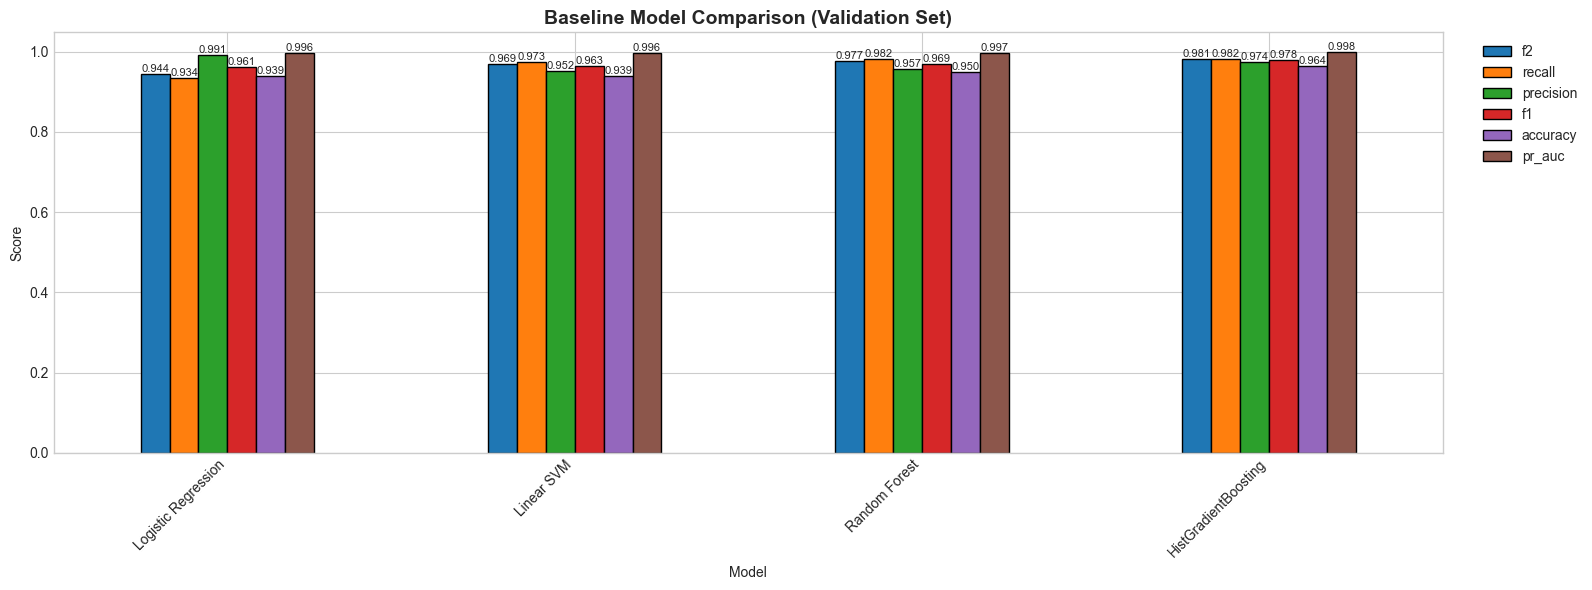

In [9]:
# Compare baseline models (with F2 as primary metric)
baseline_comparison = compare_models(
    baseline_results,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Baseline Model Comparison (Validation Set)',
    save_path='images/fp_baseline_comparison.png'
)

## 4. Hyperparameter Tuning

Tune the top-performing baseline models using cross-validation on train+val combined (80% of data). The test set remains completely held out for final evaluation.

### 4.1 Logistic Regression Tuning

In [10]:
# Logistic Regression parameter grid
# Simplified based on prior tuning: C=0.01-0.1 with class_weight=None works best
# L1/L2 penalty makes no difference at low C, so using l2 (simpler)
lr_param_grid = {
    'C': [0.01, 0.1, 1],
    'l1_ratio': [0.0, 0.5, 1.0],
    'solver': ['lbfgs'],  # faster than saga for l2
    'class_weight': ['balanced', None],
}

lr_search = create_search_object(
    search_type='grid',
    estimator=LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=cv,
    refit='f2'
)

lr_search, lr_log, lr_csv = tune_with_logging(
    lr_search, X_trainval, y_trainval,
    model_name='logistic_regression'
)


HYPERPARAMETER TUNING: logistic_regression
Total parameter combinations: 18
Cross-validation folds: 3
Total fits: 54
Log file: models/logs/logistic_regression_20260106_163902.log

Tuning complete!
Best score (f2): 0.9708
Results saved to: models/logs/logistic_regression_20260106_163902_cv_results.csv


### 4.2 Random Forest Tuning

In [11]:
# Random Forest parameter grid
# Simplified based on prior tuning:
# - n_estimators=200 dominates top runs
# - max_depth=20/None perform similarly (removing 10)
# - min_samples_leaf=1 dominates (removing 2)
# - Both class_weight options work well
rf_param_grid = {
    'n_estimators': [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300, 350],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 4, 8, 12],
    'min_samples_leaf': [1],
    'class_weight': ['balanced', None],
}

rf_search = create_search_object(
    search_type='grid',
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    refit='f2'
)

rf_search, rf_log, rf_csv = tune_with_logging(
    rf_search, X_trainval, y_trainval,
    model_name='random_forest'
)


HYPERPARAMETER TUNING: random_forest
Total parameter combinations: 416
Cross-validation folds: 3
Total fits: 1248
Log file: models/logs/random_forest_20260106_163908.log



/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning

Tuning complete!
Best score (f2): 0.9812
Results saved to: models/logs/random_forest_20260106_163908_cv_results.csv


### 4.3 HistGradientBoosting Tuning

In [12]:
# HistGradientBoosting parameter grid
# Simplified based on prior tuning:
# - learning_rate=0.1 dominates top runs
# - l2_regularization=0.0 is slightly better
# - Keeping max_iter variation to check convergence
hgb_param_grid = {
    'max_iter': [70, 80, 100, 120, 150, 200],
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [5, 10, 20],
    'l2_regularization': [0.0],
    'class_weight': [None, 'balanced'],
}

hgb_search = create_search_object(
    search_type='grid',
    estimator=HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid=hgb_param_grid,
    cv=cv,
    refit='f2'
)

# HGB requires dense arrays - convert if sparse
X_trainval_hgb = X_trainval.toarray() if sp.issparse(X_trainval) else X_trainval

hgb_search, hgb_log, hgb_csv = tune_with_logging(
    hgb_search, X_trainval_hgb, y_trainval,
    model_name='hist_gradient_boosting'
)


HYPERPARAMETER TUNING: hist_gradient_boosting
Total parameter combinations: 324
Cross-validation folds: 3
Total fits: 972
Log file: models/logs/hist_gradient_boosting_20260106_164147.log

Tuning complete!
Best score (f2): 0.9782
Results saved to: models/logs/hist_gradient_boosting_20260106_164147_cv_results.csv


### 4.4 Compare Tuned Models (CV Performance)

Compare models based on their cross-validation F2 scores. Model selection is based on CV performance, not test set performance.

In [13]:
# Compare tuned models based on CV performance
tuned_models = {
    'LR_tuned': lr_search,
    'RF_tuned': rf_search,
    'HGB_tuned': hgb_search,
}

# Extract CV metrics for comparison
cv_comparison_data = []
for name, search in tuned_models.items():
    best_idx = search.best_index_
    cv_results = search.cv_results_
    
    metrics = {
        'model_name': name,
        'f2': cv_results['mean_test_f2'][best_idx],
        'recall': cv_results['mean_test_recall'][best_idx],
        'precision': cv_results['mean_test_precision'][best_idx],
        'f1': cv_results['mean_test_f1'][best_idx],
        'accuracy': cv_results['mean_test_accuracy'][best_idx],
        'pr_auc': cv_results['mean_test_average_precision'][best_idx],
    }
    cv_comparison_data.append(metrics)
    
    print(f"{name}: CV F2 = {metrics['f2']:.4f} (+/- {cv_results['std_test_f2'][best_idx]:.4f}), Recall = {metrics['recall']:.4f}, Precision = {metrics['precision']:.4f}")

LR_tuned: CV F2 = 0.9708 (+/- 0.0035), Recall = 0.9746, Precision = 0.9559
RF_tuned: CV F2 = 0.9812 (+/- 0.0011), Recall = 0.9912, Precision = 0.9433
HGB_tuned: CV F2 = 0.9782 (+/- 0.0041), Recall = 0.9823, Precision = 0.9622



Tuned Model Comparison (CV Performance, Optimized for F2)
                f2  recall  precision      f1  accuracy  pr_auc
model_name                                                     
LR_tuned    0.9708  0.9746     0.9559  0.9651    0.9428  0.9932
RF_tuned    0.9812  0.9912     0.9433  0.9666    0.9446  0.9929
HGB_tuned   0.9782  0.9823     0.9622  0.9721    0.9545  0.9930

Figure saved to images/fp_tuned_comparison.png


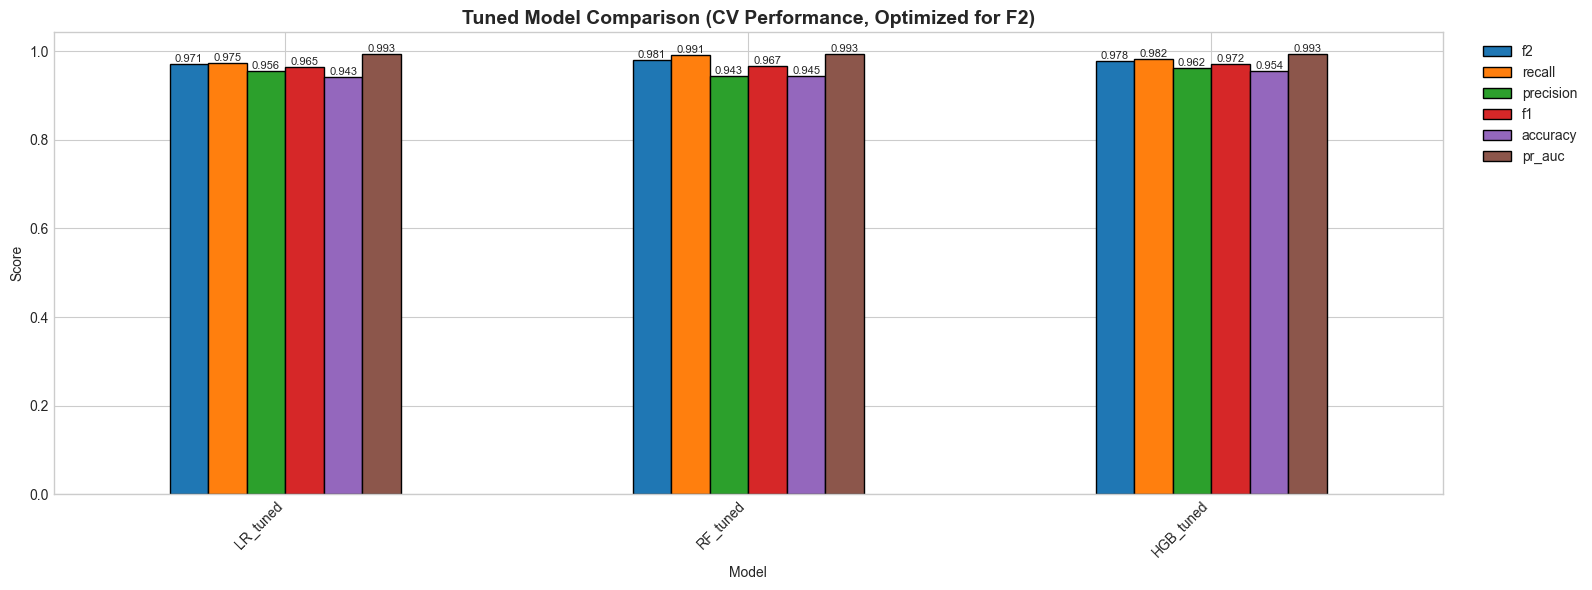

In [14]:
# Compare tuned models (F2 as primary metric)
tuned_comparison = compare_models(
    cv_comparison_data,
    metrics_to_display=['f2', 'recall', 'precision', 'f1', 'accuracy', 'pr_auc'],
    title='Tuned Model Comparison (CV Performance, Optimized for F2)',
    save_path='images/fp_tuned_comparison.png'
)

### 4.5 Top Hyperparameter Combinations

Review the top performing hyperparameter combinations for each model to guide future grid adjustments.

In [15]:
# Display top 10 hyperparameter combinations for each model
display_top_hyperparameter_runs(tuned_models, n_top=10, metric='f2')

TOP 10 HYPERPARAMETER COMBINATIONS: LR_tuned
 rank   val_f2  val_f2_std  train_f2      gap    C class_weight  l1_ratio solver
    1 0.970753    0.003536  0.982957 0.012204 0.10         None       0.0  lbfgs
    2 0.969970    0.003638  0.975198 0.005227 0.01         None       0.0  lbfgs
    3 0.969352    0.006483  0.986879 0.017528 1.00         None       0.0  lbfgs
    4 0.941903    0.007570  0.949439 0.007536 0.01     balanced       0.0  lbfgs
    5 0.940228    0.006516  0.966089 0.025862 1.00     balanced       0.0  lbfgs
    6 0.936801    0.005208  0.958346 0.021545 0.10     balanced       0.0  lbfgs
    7      NaN         NaN       NaN      NaN 0.01     balanced       1.0  lbfgs
    7      NaN         NaN       NaN      NaN 0.01     balanced       0.5  lbfgs
    7      NaN         NaN       NaN      NaN 0.10     balanced       0.5  lbfgs
    7      NaN         NaN       NaN      NaN 0.01         None       1.0  lbfgs

Best parameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0

## 5. Overfitting Analysis

Analyze the gap between training and validation performance using CV results. This analysis uses only training data (through cross-validation) and does NOT use the held-out test set.

**Key insight**: In GridSearchCV, `mean_train_*` scores are computed on the training folds and `mean_test_*` scores are computed on the validation folds. A large gap indicates overfitting.

### 5.1 Train-Validation Gap Summary

In [16]:
# Get summary of train-validation gaps for all tuned models
gap_summary_df = get_gap_summary(tuned_models, metric='f2')


TRAIN-VALIDATION GAP SUMMARY (F2)

Gap thresholds: Warning >= 5%, Severe >= 10%

--------------------------------------------------------------------------------

✓ LR_tuned:
    Train f2: 0.9830 (+/- 0.0034)
    Val f2:   0.9708 (+/- 0.0035)
    Gap:        0.0122 (1.2%) [Good]

✓ RF_tuned:
    Train f2: 0.9998 (+/- 0.0002)
    Val f2:   0.9812 (+/- 0.0011)
    Gap:        0.0186 (1.9%) [Good]

✓ HGB_tuned:
    Train f2: 1.0000 (+/- 0.0000)
    Val f2:   0.9782 (+/- 0.0041)
    Gap:        0.0218 (2.2%) [Good]



Best model by CV F2: RF_tuned

Analyzing train-validation gap for best model...

Random Forest - Train-Validation Gap Analysis

Metric: f2
  Training score:   0.9998
  Validation score: 0.9812
  Gap:              0.0186 (1.9%)

Diagnosis: Good fit
  (Warning threshold: 5%, Severe threshold: 10%)
  Figure saved: images/fp_rf_tuned_train_val_gap.png


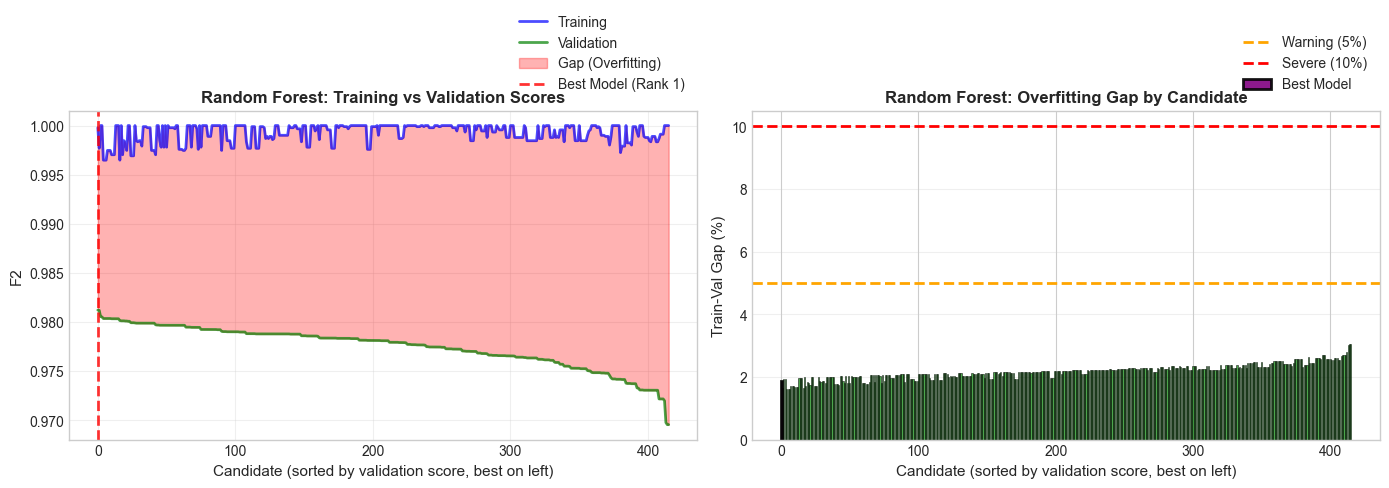

In [17]:
# Identify the best model from CV comparison
best_cv_model_name = max(cv_comparison_data, key=lambda x: x['f2'])['model_name']
best_cv_search = tuned_models[best_cv_model_name]

# Map model names to display names
model_display_names = {
    'LR_tuned': 'Logistic Regression',
    'RF_tuned': 'Random Forest', 
    'HGB_tuned': 'HistGradientBoosting',
}

print(f"Best model by CV F2: {best_cv_model_name}")
print(f"\nAnalyzing train-validation gap for best model...")

# Detailed train-validation gap analysis for best model
best_gap_result = analyze_cv_train_val_gap(
    best_cv_search, 
    metric='f2',
    model_name=model_display_names.get(best_cv_model_name, best_cv_model_name),
    save_path=f'images/fp_{best_cv_model_name.lower()}_train_val_gap.png'
)

### 5.2 Performance vs Complexity Parameter

Analyze how the best model's performance changes with its primary complexity parameter (n_estimators for RF, max_iter for HGB, C for LR), using optimal values for other parameters from tuning.

In [18]:
# Configuration for iteration analysis by model type
# Maps model name to: (param_name, param_values, estimator_class, fixed_params_to_copy)
iteration_configs = {
    'RF_tuned': {
        'param_name': 'n_estimators',
        'param_values': [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300, 350, 400],
        'estimator_class': RandomForestClassifier,
        'fixed_params': ['max_depth', 'min_samples_split', 'min_samples_leaf', 'class_weight'],
        'extra_params': {'random_state': RANDOM_STATE, 'n_jobs': -1},
        'requires_dense': False,
    },
    'HGB_tuned': {
        'param_name': 'max_iter',
        'param_values': [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300],
        'estimator_class': HistGradientBoostingClassifier,
        'fixed_params': ['learning_rate', 'max_depth', 'min_samples_leaf', 'l2_regularization', 'class_weight'],
        'extra_params': {'random_state': RANDOM_STATE},
        'requires_dense': True,
    },
    'LR_tuned': {
        'param_name': 'C',
        'param_values': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
        'estimator_class': LogisticRegression,
        'fixed_params': ['l1_ratio', 'solver', 'class_weight'],
        'extra_params': {'max_iter': 2000, 'random_state': RANDOM_STATE},
        'requires_dense': False,
    },
}

# Get configuration for best model
if best_cv_model_name in iteration_configs:
    config = iteration_configs[best_cv_model_name]
    best_params = best_cv_search.best_params_.copy()
    
    print(f"Analyzing {config['param_name']} performance for {model_display_names[best_cv_model_name]}")
    print(f"Testing values: {config['param_values']}")
    
    # Build param grid with all params fixed except the iteration param
    iteration_param_grid = {config['param_name']: config['param_values']}
    for param in config['fixed_params']:
        if param in best_params:
            iteration_param_grid[param] = [best_params[param]]
    
    # Create and run grid search
    iteration_search = create_search_object(
        search_type='grid',
        estimator=config['estimator_class'](**config['extra_params']),
        param_grid=iteration_param_grid,
        cv=cv,
        refit='f2'
    )
    
    # Use appropriate data format
    X_iteration = X_trainval_hgb if config['requires_dense'] else X_trainval
    
    iteration_search, _, _ = tune_with_logging(
        iteration_search, X_iteration, y_trainval,
        model_name=f'{best_cv_model_name.lower()}_iterations'
    )
else:
    print(f"No iteration analysis configured for {best_cv_model_name}")
    iteration_search = None

Analyzing n_estimators performance for Random Forest
Testing values: [30, 40, 50, 60, 70, 80, 100, 120, 150, 200, 250, 300, 350, 400]

HYPERPARAMETER TUNING: rf_tuned_iterations
Total parameter combinations: 14
Cross-validation folds: 3
Total fits: 42
Log file: models/logs/rf_tuned_iterations_20260106_164446.log

Tuning complete!
Best score (f2): 0.9812
Results saved to: models/logs/rf_tuned_iterations_20260106_164446_cv_results.csv



Random Forest - n_estimators Performance Analysis

Metric: f2

Optimal n_estimators: 120
  Training F2:   0.9998
  Validation F2: 0.9812
  Gap:               0.0186 (1.9%)

Tuned n_estimators from hyperparameter search: 120
  Training F2:   0.9998
  Validation F2: 0.9812
  Gap:               0.0186 (1.9%)
  Figure saved: images/fp_rf_tuned_iteration_performance.png


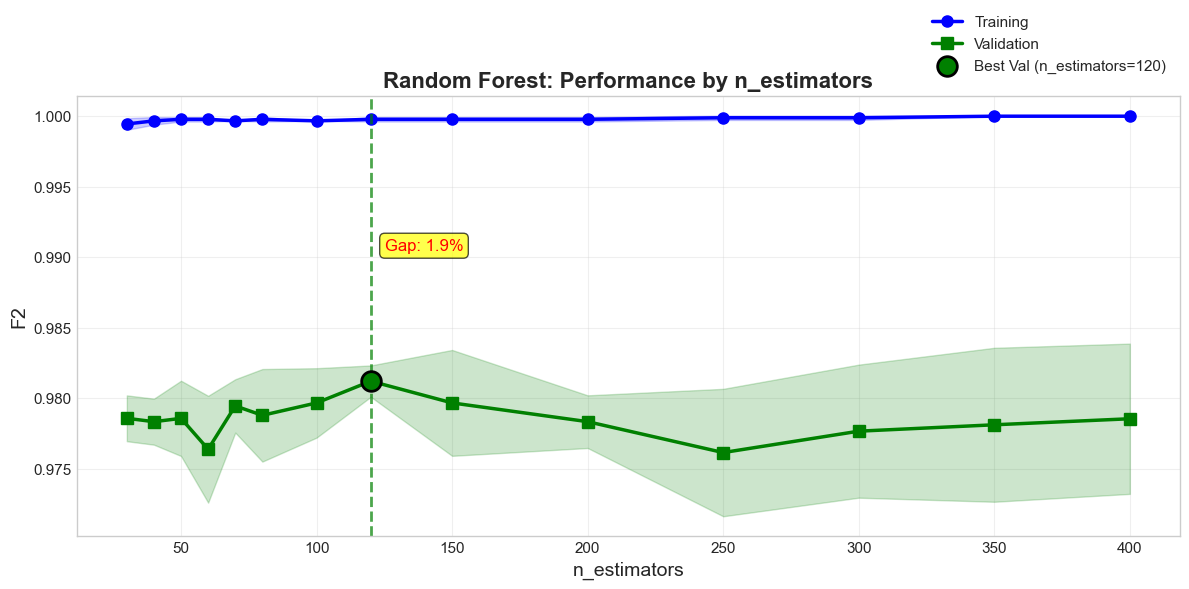

In [19]:
# Analyze performance across parameter values with confidence bands
if iteration_search is not None:
    config = iteration_configs[best_cv_model_name]
    
    # Get the tuned value from main hyperparameter search
    tuned_value = best_cv_search.best_params_.get(config['param_name'])
    
    iteration_result = analyze_iteration_performance(
        iteration_search,
        param_name=config['param_name'],
        metric='f2',
        tuned_value=tuned_value,
        model_name=model_display_names[best_cv_model_name],
        save_path=f'images/fp_{best_cv_model_name.lower()}_iteration_performance.png'
    )
else:
    print("Skipping iteration performance analysis")

## 6. Final Model Selection

Select the best model based on CV F2 score and save artifacts for final evaluation in fp3.

**Note:** Test set evaluation, threshold optimization, and deployment are performed in fp3_model_evaluation_deployment.ipynb.

In [20]:
# Select best model based on CV F2
best_model_name, best_model_metrics = get_best_model(tuned_comparison, 'f2')
print(f"Selected model: {best_model_name}")
print(f"CV F2: {best_model_metrics['f2']:.4f} (primary metric)")
print(f"CV Recall: {best_model_metrics['recall']:.4f}")
print(f"CV Precision: {best_model_metrics['precision']:.4f}")

# Get the best fitted model
best_search = tuned_models[best_model_name]
best_model = best_search.best_estimator_

# Save best classifier for fp3
classifier_path = MODELS_DIR / 'fp_best_classifier.joblib'
joblib.dump(best_model, classifier_path)
print(f"\nBest classifier saved to: {classifier_path}")


Best model by f2: RF_tuned
Score: 0.9812
Selected model: RF_tuned
CV F2: 0.9812 (primary metric)
CV Recall: 0.9912
CV Precision: 0.9433

Best classifier saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_best_classifier.joblib


In [21]:
# Save CV metrics for comparison in fp3
cv_metrics = {
    'model_name': best_model_name,
    'cv_f2': float(best_model_metrics['f2']),
    'cv_recall': float(best_model_metrics['recall']),
    'cv_precision': float(best_model_metrics['precision']),
    'cv_f1': float(best_model_metrics['f1']),
    'cv_accuracy': float(best_model_metrics['accuracy']),
    'cv_pr_auc': float(best_model_metrics['pr_auc']),
    'best_params': best_search.best_params_,
    'transformer_method': transformer.method,
    'n_folds': N_FOLDS,
}

cv_metrics_path = MODELS_DIR / 'fp_cv_metrics.json'
with open(cv_metrics_path, 'w') as f:
    json.dump(cv_metrics, f, indent=2)
print(f"CV metrics saved to: {cv_metrics_path}")

CV metrics saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_cv_metrics.json


In [22]:
print("=" * 60)
print("FP2 NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Feature Method: {transformer.method}")
print(f"\nCV Performance ({N_FOLDS}-fold):")
print(f"  F2 Score:  {best_model_metrics['f2']:.4f}")
print(f"  Recall:    {best_model_metrics['recall']:.4f}")
print(f"  Precision: {best_model_metrics['precision']:.4f}")
print(f"\nBest Hyperparameters:")
for param, value in best_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nSaved Artifacts for fp3:")
print(f"  - {classifier_path}")
print(f"  - {cv_metrics_path}")
print(f"\nNext: Run fp3_model_evaluation_deployment.ipynb for:")
print(f"  - Final test set evaluation")
print(f"  - Threshold optimization")
print(f"  - Pipeline export for deployment")
print("=" * 60)

FP2 NOTEBOOK SUMMARY

Best Model: RF_tuned
Feature Method: tfidf_lsa_ner_proximity_brands

CV Performance (3-fold):
  F2 Score:  0.9812
  Recall:    0.9912
  Precision: 0.9433

Best Hyperparameters:
  class_weight: None
  max_depth: 15
  min_samples_leaf: 1
  min_samples_split: 4
  n_estimators: 120

Saved Artifacts for fp3:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_best_classifier.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_cv_metrics.json

Next: Run fp3_model_evaluation_deployment.ipynb for:
  - Final test set evaluation
  - Threshold optimization
  - Pipeline export for deployment


In [23]:
# Export unified training config for train.py script
# This config contains everything needed to reproduce training from scratch
from src.deployment.training_config import (
    TrainingConfig,
    FeatureEngineeringConfig,
    ModelConfig,
    CVMetrics,
)

# Map tuned model names to sklearn class names
MODEL_NAME_MAP = {
    'LR_tuned': 'LogisticRegression',
    'RF_tuned': 'RandomForest',
    'HGB_tuned': 'HistGradientBoosting',
    'SVM_tuned': 'SVM',
}

# Create the training config
training_config = TrainingConfig(
    classifier_type='fp',
    feature_engineering=FeatureEngineeringConfig(
        method=transformer.method,
        params=transformer_config,
    ),
    model=ModelConfig(
        type=MODEL_NAME_MAP.get(best_model_name, best_model_name),
        params=best_search.best_params_,
        calibrated=False,  # RF doesn't need calibration
    ),
    cv_metrics=CVMetrics(
        f2=best_model_metrics['f2'],
        recall=best_model_metrics['recall'],
        precision=best_model_metrics['precision'],
        f1=best_model_metrics['f1'],
        accuracy=best_model_metrics['accuracy'],
        pr_auc=best_model_metrics['pr_auc'],
        n_folds=N_FOLDS,
    ),
    notebook='fp2_model_selection_tuning.ipynb',
)

# Save training config
training_config_path = MODELS_DIR / 'fp_training_config.json'
training_config.save(training_config_path)

print(f"Training config saved to: {training_config_path}")
print(f"\nConfig summary:")
print(f"  Classifier: {training_config.classifier_type}")
print(f"  Model: {training_config.model.type}")
print(f"  Feature method: {training_config.feature_engineering.method}")
print(f"  CV F2: {training_config.cv_metrics.f2:.4f}")

Training config saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_training_config.json

Config summary:
  Classifier: fp
  Model: RandomForest
  Feature method: tfidf_lsa_ner_proximity_brands
  CV F2: 0.9812
